# Displayment-controlled Raw Data Pre-processing

In this notebook, we pre-process the simulation data to generate training, validation, and test data. In particular, we transform the simulation force output as gray-scale images.

In [82]:
import numpy as np
import pandas as pd
import scipy.io
import re
import cv2

from random import sample
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from glob import glob
from json import load, dump
from os.path import basename
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
from collections import Counter
from random import sample
from tqdm import tqdm

from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

seed = 4222021
np.random.seed(seed)

## 1. Read the experiment point data

In [3]:
sim_id = 0
input_df = pd.read_csv('./data/data-12-01/Disp_{}.out'.format(sim_id))
input_dict = {}

In [4]:
input_df.head()

,0,-90,-85,-80,-75,-70,-65,-60,-55,-50,...,45,50,55,60,65,70,75,80,85,90
0,1.220551e-33,910.790466,829.024255,820.280910,805.773125,785.709558,760.282492,729.815691,694.660372,655.285243,...,662.042087,704.317966,742.800103,777.019389,806.553960,831.125276,850.458488,864.404466,872.802583,956.801390
1,2.481288e-06,910.909455,829.162294,820.421294,805.915906,785.857512,760.426198,729.951995,694.791890,655.420279,...,662.086222,704.361914,742.837327,777.037856,806.550136,831.103484,850.426136,864.367042,872.763776,956.737278
2,1.970120e-05,911.213016,829.595642,820.853227,806.347640,786.294124,760.857741,730.397408,695.240165,655.876408,...,662.557841,704.812156,743.288380,777.480792,806.993480,831.545204,850.866105,864.807031,873.201795,957.044885
3,6.599036e-05,911.972890,830.727479,821.988282,807.484494,787.433210,762.009956,731.565160,696.440838,657.109874,...,663.836392,706.057261,744.492600,778.667523,808.164580,832.712914,852.026931,865.969338,874.361304,957.853777
4,1.552384e-04,913.431017,832.878103,824.142284,809.642511,789.598430,764.195979,733.775954,698.701130,659.454675,...,666.271006,708.406749,746.788877,780.932026,810.408548,834.950351,854.256562,868.199897,876.589523,959.414566


In [5]:
np.linspace(-90, 90, 37)

array([-90., -85., -80., -75., -70., -65., -60., -55., -50., -45., -40.,
       -35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,
        20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.,  90.])

In [6]:
positions, indexes, values = [], [], []
angles = list(map(int, np.linspace(-90, 90, 37)))

for i, row in input_df.iterrows():
    for j in range(1, len(row)):
        positions.append(angles[j - 1])
        indexes.append(i)
        values.append(row[j])

Text(0.5, 0, 'Pressure')

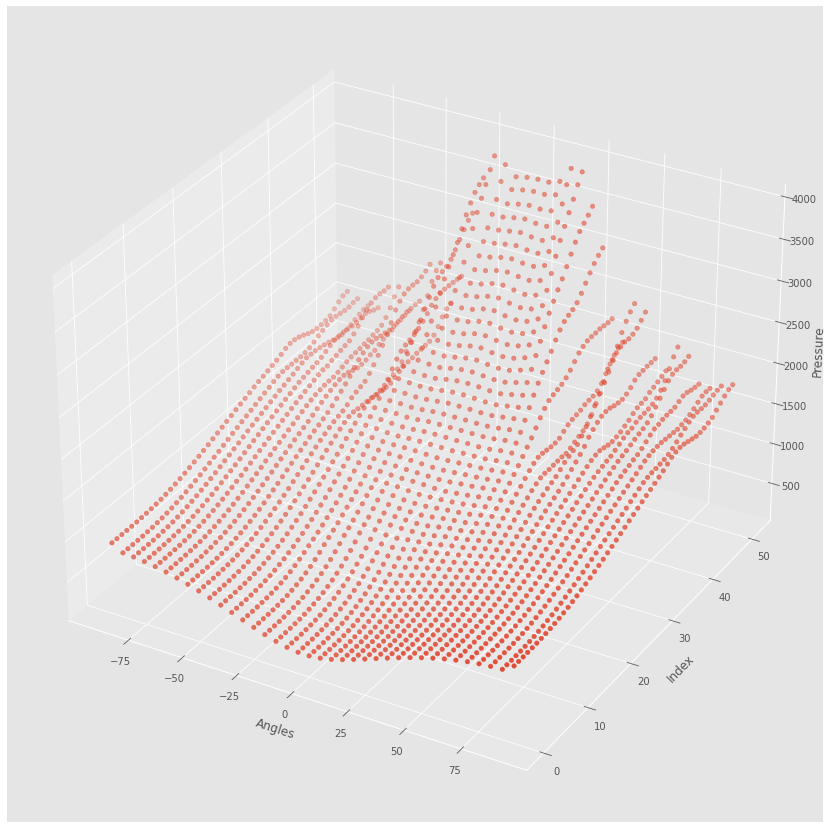

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=positions, ys=indexes, zs=values, marker='o')
ax.set_xlabel('Angles')
ax.set_ylabel('Index')
ax.set_zlabel('Pressure')

In [8]:
# heatmap = np.zeros((max(indexes) + 1, 37))

# for i in range(len(positions)):
#     heatmap[indexes[i], angles.index(positions[i])] = values[i]

heatmap = input_df.to_numpy()[:, 1:]

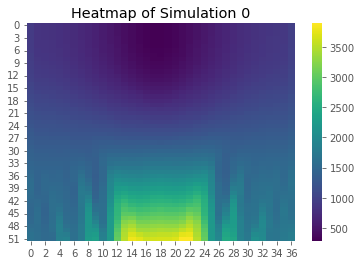

In [9]:
plt.title('Heatmap of Simulation {}'.format(sim_id))
seaborn.heatmap(heatmap, cmap='viridis')
plt.show()

### 1.1. Get Heatmap of All Simulations

In [10]:
def extract_heatmap(sim_id):
    """
    Extract heatmap from the simulation output file.
    """
    angles = list(map(int, np.linspace(-90, 90, 37)))
    input_df = pd.read_csv('./data/data-12-01/Disp_{}.out'.format(sim_id))
    heatmap = input_df.to_numpy()[:, 1:]
    return heatmap

In [11]:
heatmaps = []
heatmaps_ids = []

for f in tqdm(glob('./data/data-12-01/*.out')):
    sim_id = int(re.sub(r'Disp_(.*)\.out', r'\1', basename(f)))
    heatmaps_ids.append(sim_id)
    heatmap = extract_heatmap(sim_id)
    heatmaps.append(heatmap)

100%|██████████████████████████████████████| 1363/1363 [00:03<00:00, 406.09it/s]


In [12]:
mins = []
maxs = []

for h in heatmaps:
    mins.append(np.min(h))
    maxs.append(np.max(h))

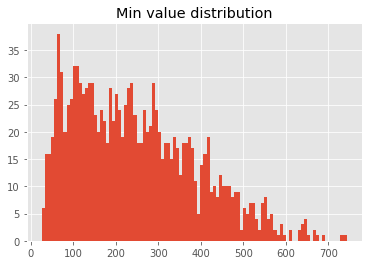

In [13]:
plt.hist(mins, bins=100)
plt.title('Min value distribution')
plt.show()

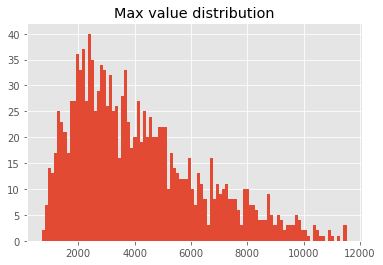

In [14]:
plt.hist(maxs, bins=100)
plt.title('Max value distribution')
plt.show()

In [18]:
# for i in tqdm(range(len(heatmaps))):
#     plt.title('Heatmap of Simulation {}'.format(i))
#     seaborn.heatmap(heatmaps[i], cmap='viridis', cbar=False)
#     plt.savefig('./plots/displayment-heatmaps/heatmap-{:04}.png'.format(i), dpi=150)

#### Random 100 Heatmaps

![](./plots/displayment-heatmaps/random-100.png)

## 1.2. Standardize or Normalize Heatmap Scale

To save heatmaps as images, we need an uniform scale for the stress value.

In [21]:
min_stress, max_stress = np.min(mins), np.max(maxs)
print(min_stress, max_stress)

27.0866533478187 11519.2058065428


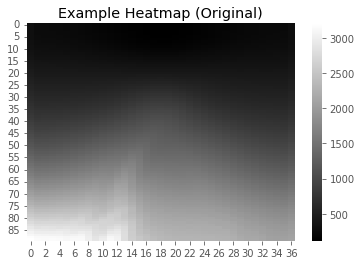

In [22]:
cur_heatmap = heatmaps[100]

plt.title('Example Heatmap (Original)')
seaborn.heatmap(cur_heatmap, cmap='gray')
plt.show()

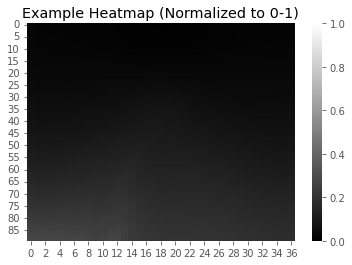

In [23]:
normalized_heatmap = (cur_heatmap - min_stress) / (max_stress - min_stress)

plt.title('Example Heatmap (Normalized to 0-1)')
seaborn.heatmap(normalized_heatmap, cmap='gray', vmin=0, vmax=1)
plt.show()

In [24]:
all_heatmaps = np.vstack(heatmaps)
heatmap_mean = np.mean(all_heatmaps)
heatmap_sd = np.std(all_heatmaps)
print(heatmap_mean, heatmap_sd)

2106.803229276184 1977.386533299943


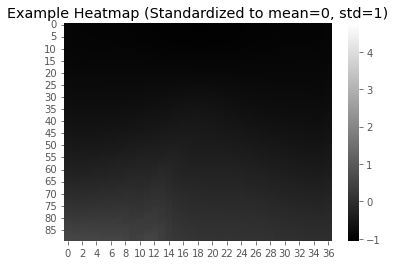

In [25]:
all_heatmaps_standardized = (all_heatmaps - heatmap_mean) / heatmap_sd
std_v_min, std_v_max = np.min(all_heatmaps_standardized), np.max(all_heatmaps_standardized)


standardized_heatmap = (cur_heatmap - heatmap_mean) / heatmap_sd

plt.title('Example Heatmap (Standardized to mean=0, std=1)')
seaborn.heatmap(standardized_heatmap, cmap='gray', vmin=std_v_min, vmax=std_v_max)
plt.show()

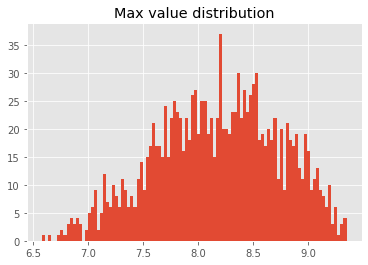

In [26]:
plt.hist(np.log(maxs), bins=100)
plt.title('Max value distribution')
plt.show()

In [27]:
normalized_heatmap

array([[0.02356901, 0.01959567, 0.01939192, ..., 0.01786387, 0.01803499,
        0.02168706],
       [0.02357079, 0.01960181, 0.01939805, ..., 0.01786997, 0.01804112,
        0.02168883],
       [0.02358299, 0.01964424, 0.01944034, ..., 0.01791206, 0.01808334,
        0.02170096],
       ...,
       [0.26793381, 0.26432134, 0.26339809, ..., 0.17448591, 0.17467537,
        0.1775271 ],
       [0.27387749, 0.27008255, 0.26949037, ..., 0.17626703, 0.17652381,
        0.1788507 ],
       [0.27670868, 0.27161332, 0.27121432, ..., 0.17670402, 0.17706093,
        0.17923946]])

In [28]:
max_height = 0
heights = []

for h in heatmaps:
    heights.append(h.shape[0])
    if h.shape[0] > max_height:
        max_height = h.shape[0]

max_height

201

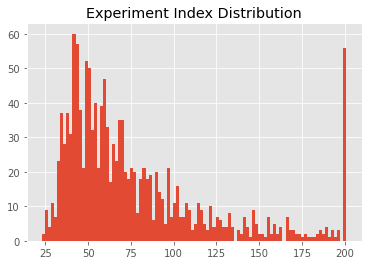

In [29]:
plt.hist(heights, bins=100)
plt.title('Experiment Index Distribution')
plt.show()

In [30]:
normalized_heatmaps = []

for h in tqdm(range(len(heatmaps))):
    cur_img = np.zeros((max_height, 37))
    cur_heatmap = heatmaps[h]
    normalized_heatmap = (cur_heatmap - min_stress) / (max_stress - min_stress)
    cur_img[:cur_heatmap.shape[0], :] = normalized_heatmap
    
    normalized_heatmaps.append(cur_img)
#     cur_img_uint = np.array(255 * cur_img, np.uint8)
#     cv2.imwrite('./plots/displayment-images/img-{:04}.png'.format(h), cur_img_uint)
    
np.savez_compressed('./data/displayment-heatmaps-normalized.npz',
                    normalized_heatmaps=normalized_heatmaps, dtype=object)

100%|████████████████████████████████████| 1363/1363 [00:00<00:00, 19169.48it/s]


#### 100 Random Images

![](./plots/displayment-images/random-100.png)

## 1.3. Resize the Images

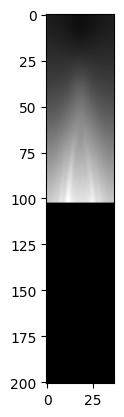

In [31]:
plt.style.use('default')
plt.imshow(normalized_heatmaps[2], cmap='gray')
plt.show()

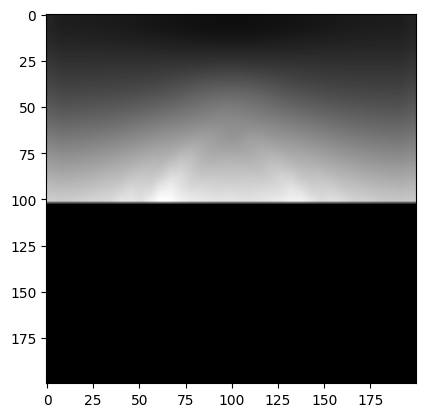

In [32]:
resized = cv2.resize(normalized_heatmaps[2], (200, 200))
plt.imshow(resized, cmap='gray')
plt.show()

In [33]:
rs_normalized_heatmaps = []

for h in tqdm(range(len(heatmaps))):
    cur_heatmap = heatmaps[h]
    normalized_heatmap = (cur_heatmap - min_stress) / (max_stress - min_stress)
    normalized_heatmap = cv2.resize(normalized_heatmap, (256, 256))
    
    rs_normalized_heatmaps.append(normalized_heatmap)
#     cur_img_uint = np.array(255 * normalized_heatmap, np.uint8)
#     cv2.imwrite('./plots/displayment-images-resized/img-{:04}.png'.format(h),
#                 cur_img_uint)
    
np.savez_compressed('./data/displayment-heatmaps-normalized-resized.npz',
                    rs_normalized_heatmaps=rs_normalized_heatmaps,
                    heatmaps_ids=heatmaps_ids,
                    dtype=object)

100%|█████████████████████████████████████| 1363/1363 [00:00<00:00, 3284.36it/s]


In [35]:
# !cd plots/displayment-images-resized; montage $(ls | shuf -n 100) -geometry +2+2 random-100.png

#### 100 Random Images

<img src='./plots/displayment-images-resized/random-100.png'>

## 2. Alternative Image Interpolation

We can linearly interpolate the images so that each step encodes the same increasement across simulations.

### 2.1. Extract Image Data

In [44]:
def extract_heatmap(sim_id):
    """
    Extract heatmap from the simulation output file.
    """
    angles = list(map(int, np.linspace(-90, 90, 37)))
    input_df = pd.read_csv('./data/data-12-01/Disp_{}.out'.format(sim_id))
    heatmap = input_df.to_numpy()[:, 1:]
    er = input_df.to_numpy()[:, 0]
    return heatmap, er

In [45]:
heatmaps = []
heatmaps_ids = []
heatmaps_ers = []

for f in tqdm(glob('./data/data-12-01/*.out')):
    sim_id = int(re.sub(r'Disp_(.*)\.out', r'\1', basename(f)))
    heatmaps_ids.append(sim_id)
    heatmap, er = extract_heatmap(sim_id)
    heatmaps.append(heatmap)
    heatmaps_ers.append(er)
    
heatmaps_ids = np.array(heatmaps_ids)
heatmaps_ers = np.array(heatmaps_ers)

100%|██████████████████████████████████████| 1363/1363 [00:03<00:00, 405.52it/s]
/tmp/ipykernel_4150/924212282.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  heatmaps_ers = np.array(heatmaps_ers)


In [46]:
# Map the heatmap ID order to the curve fitting table row index
output_files = glob('./data/data-12-01/*.out')
output_files = sorted(output_files)
heatmps_id_to_fit_index = {}

for (i, f) in enumerate(output_files):
    sim_id = int(re.sub(r'Disp_(.*)\.out', r'\1', basename(f)))
    heatmps_id_to_fit_index[sim_id] = i

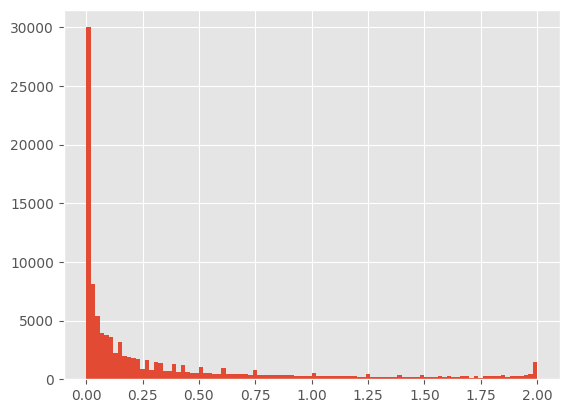

In [47]:
all_ers = np.hstack(heatmaps_ers)
plt.style.use('ggplot')

plt.hist(all_ers, bins=100)
plt.show()

In [48]:
np.sum(all_ers > 0.01) / len(all_ers)

0.7798877162317491

In [49]:
np.sum(all_ers > 0.1) / len(all_ers)

0.5136269937018495

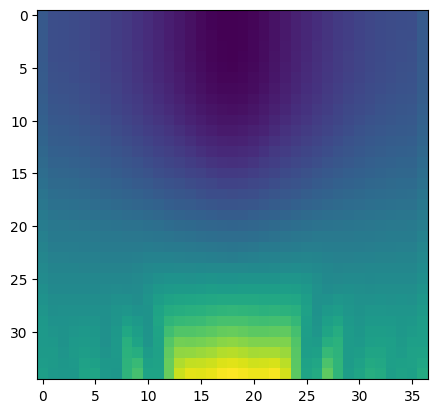

In [66]:
plt.style.use('default')
plt.imshow(heatmaps[0])

In [67]:
heatmaps_ers[0]

array([3.67480814e-34, 2.48128754e-06, 1.97011996e-05, 6.59903599e-05,
       1.55238406e-04, 3.00898449e-04, 5.15991589e-04, 8.13111488e-04,
       1.20442885e-03, 1.70169561e-03, 2.31625000e-03, 3.05902073e-03,
       3.94053105e-03, 4.97090491e-03, 6.15986856e-03, 7.51675759e-03,
       9.05052200e-03, 1.07697258e-02, 1.26825590e-02, 1.47968354e-02,
       1.71200000e-02, 1.96591355e-02, 2.24209614e-02, 2.54118443e-02,
       2.86377985e-02, 3.21044922e-02, 3.58172506e-02, 3.97810638e-02,
       4.40005884e-02, 4.84801494e-02, 5.32237515e-02, 5.82350753e-02,
       6.35174885e-02, 6.90740570e-02, 7.31112957e-02])

In [68]:
# Interpolate horizontally with the fitting parameters

cur_hid = heatmaps_ids[0]
fit_id = heatmps_id_to_fit_index[cur_hid]
fit_mat = scipy.io.loadmat('./data/fit-data/fit_{}.mat'.format(fit_id + 1))['table']

![](https://i.imgur.com/W78vaKW.png)

In [70]:
np.linspace(-np.pi / 2, np.pi / 2, 50)

array([-1.57079633, -1.50668219, -1.44256806, -1.37845392, -1.31433978,
       -1.25022565, -1.18611151, -1.12199738, -1.05788324, -0.9937691 ,
       -0.92965497, -0.86554083, -0.8014267 , -0.73731256, -0.67319843,
       -0.60908429, -0.54497015, -0.48085602, -0.41674188, -0.35262775,
       -0.28851361, -0.22439948, -0.16028534, -0.0961712 , -0.03205707,
        0.03205707,  0.0961712 ,  0.16028534,  0.22439948,  0.28851361,
        0.35262775,  0.41674188,  0.48085602,  0.54497015,  0.60908429,
        0.67319843,  0.73731256,  0.8014267 ,  0.86554083,  0.92965497,
        0.9937691 ,  1.05788324,  1.12199738,  1.18611151,  1.25022565,
        1.31433978,  1.37845392,  1.44256806,  1.50668219,  1.57079633])

In [71]:
def row_interpolate(original_mat, fit_mat, dim):
    """
    Interpolate the horizontal rows from the original matrix using fit parameters
    to the targeting dimension.
    """
    
    def fit_func(a0, a1, a2, a3, a4):
        return lambda theta: (a0 + a1 * np.cos(theta) + a2 * np.cos(2 * theta) +
            a3 * np.cos(3 * theta) + a4 * np.cos(4 * theta))
        
    interpolated_mat = np.zeros((original_mat.shape[0], dim))
    
    for i in range(interpolated_mat.shape[0]):
        cur_fit_func = fit_func(fit_mat[i, 0], fit_mat[i, 1], fit_mat[i, 2],
                                fit_mat[i, 3], fit_mat[i, 4])
        
        thetas = np.linspace(0, np.pi, dim)
        
        for j in range(dim):
            interpolated_mat[i, j] = cur_fit_func(thetas[j])
            
    return interpolated_mat

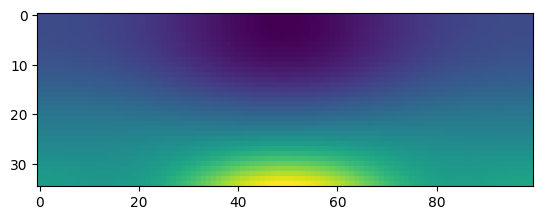

In [72]:
interpolated = row_interpolate(heatmaps[0], fit_mat, 100)
plt.imshow(interpolated)
plt.show()

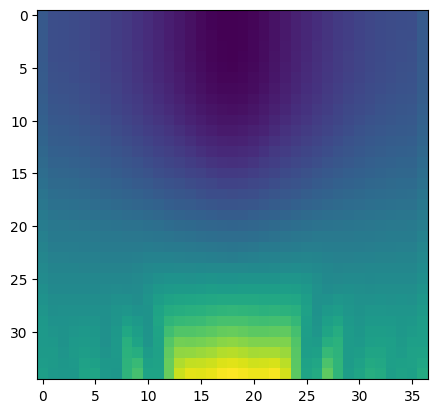

In [73]:
plt.imshow(heatmaps[0])
plt.show()

In [76]:
df = pd.read_csv('./data/Disp_Output.csv')
df.head()

,Folder,Depth,d,E,v,phi,psi,c,sv,sh,Delft_inf,Delft_sug,Exists,yield_angle,yield_stress,yield_strain,ID,Ko
0,Disp_0,42,2108.58,49040300,0.292470,44.522842,14.1261,4999.998647,868.777132,259.596199,6113.901626,6089.417004,1,NaN,inf,inf,1,0.298806
1,Disp_1,42,2378.76,30544100,0.384267,30.984098,19.1708,4999.998860,980.096695,475.542763,4251.249310,4241.385338,1,NaN,inf,inf,2,0.485200
2,Disp_10,26,1943.92,54098200,0.277512,31.420224,17.8703,4999.994369,495.816235,237.341833,3442.231579,3367.061231,1,NaN,inf,inf,3,0.478689
3,Disp_100,37,2341.64,98842600,0.302208,36.306435,13.4055,4999.997057,849.945071,346.689454,6781.475357,6706.207493,1,NaN,inf,inf,4,0.407896
4,Disp_1000,18,1794.09,51484900,0.339554,43.157792,14.0802,5000.006868,316.800412,100.105789,3325.922880,3142.177730,1,NaN,inf,inf,5,0.315990


Use the `sv` column

In [79]:
# # Create interpolated heatmaps for all heatmaps

heatmaps_interpolated = []
dim = 500

for i in tqdm(range(len(heatmaps))):
    cur_hid = heatmaps_ids[i]
    cur_mid = heatmps_id_to_fit_index[cur_hid]
    fit_mat = scipy.io.loadmat('./data/fit-data/fit_{}.mat'.format(cur_mid + 1))['table']
    
    assert(fit_mat.shape[0] == heatmaps[i].shape[0])
    
    inter = row_interpolate(heatmaps[i], fit_mat, dim)
    
    # Normalize the value of new heatmap using sv
    inter /= df.iloc[cur_mid, 8]
    
    heatmaps_interpolated.append(inter)

100%|███████████████████████████████████████| 1363/1363 [05:47<00:00,  3.93it/s]


In [80]:
heatmaps_interpolated[0]

array([[0.98329508, 0.98328125, 0.98323977, ..., 0.98741682, 0.98745385,
        0.98746619],
       [0.98331545, 0.98330166, 0.98326029, ..., 0.98760753, 0.98764473,
        0.98765713],
       [0.98418584, 0.98417205, 0.98413071, ..., 0.98844255, 0.98847973,
        0.98849211],
       ...,
       [1.80930809, 1.80928978, 1.80923491, ..., 1.88969188, 1.88975388,
        1.88977456],
       [1.8296593 , 1.82963853, 1.82957625, ..., 1.91778256, 1.91785294,
        1.91787642],
       [1.84149601, 1.84147381, 1.84140728, ..., 1.93554988, 1.93562537,
        1.93565055]])

In [83]:
train_hids, temp_hids = train_test_split(heatmaps_ids, test_size=0.4, random_state=seed)
vali_hids, test_hids = train_test_split(temp_hids, test_size=0.2, random_state=seed)

In [84]:
# Get the max expansion rate from the training set

def get_unit_sizes(heatmaps_er):
    unit_sizes = []
    
    # unit_sizes.append(1)

    for i in heatmaps_er:
        unit_sizes.append(1 * (1 + i))
    
    return unit_sizes

def get_unit_sizes_increasing(heatmaps_er):
    unit_sizes = []
    unit_sizes.append(heatmaps_er[0])

    for i in heatmaps_er[1:]:
        unit_sizes.append(unit_sizes[-1] + i)
    
    return unit_sizes

heatmaps_ers[0]
heatmaps_unit_sizes = []
train_heatmap_indexes = []
train_hids_set = set(train_hids)

for i in range(len(heatmaps_ids)):
    heatmaps_unit_sizes.append(get_unit_sizes(heatmaps_ers[i]))
    if heatmaps_ids[i] in train_hids_set:
        train_heatmap_indexes.append(i)

[1, ]
0.5, 0.6, 0.7

1, 1 * (1 + 0.5), 1 * (1 + 0.5) * (1 + 0.2)

1, 1 * (1 + 0.5), 1 * (1 + 0.2), 1 * (1 + 0.3)

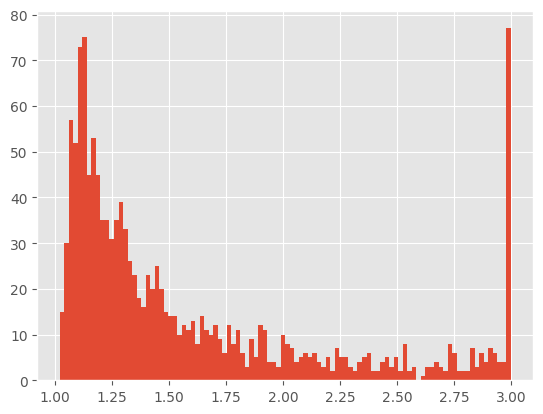

In [85]:
accumulated_er_max = [np.max(h) for h in heatmaps_unit_sizes]

plt.hist(accumulated_er_max, bins=100)
plt.show()

In [86]:
heatmaps[0].shape

(35, 37)

In [87]:
max_acc_er = 1.48
er_gap = 0.04

new_heatmaps = []

for i in tqdm(range(len(heatmaps))):

    new_heatmap = np.zeros((int(max_acc_er / er_gap), heatmaps[i].shape[1]))

    for j in range(heatmaps[i].shape[1]):
        cur_ys = heatmaps[i][:, j]
        interpolated_ys = np.interp(np.linspace(0, max_acc_er, int(max_acc_er / er_gap)),
                                    heatmaps_unit_sizes[i],
                                    cur_ys)
        new_heatmap[:, j] = interpolated_ys
    
    new_heatmaps.append(new_heatmap)

100%|██████████████████████████████████████| 1363/1363 [00:01<00:00, 722.02it/s]


In [88]:
cur_ys = heatmaps[1][:, 2]
interpolated_ys = np.interp(np.linspace(0, max_acc_er, int(max_acc_er / er_gap)),
                            heatmaps_unit_sizes[1],
                            cur_ys)

Text(0.5, 1.0, 'Size at Each Step of Sim 1')

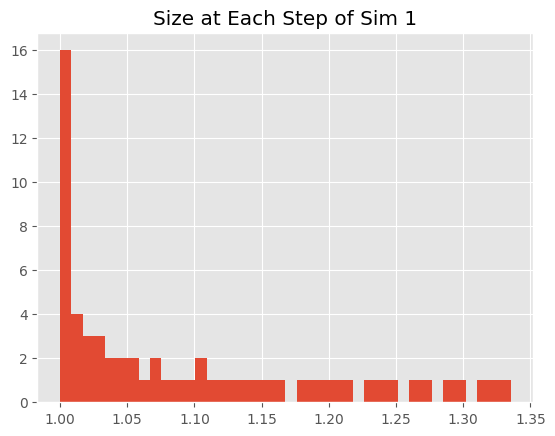

In [89]:
plt.hist(heatmaps_unit_sizes[1], bins=40)
plt.title('Size at Each Step of Sim 1')

(array([25.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  5.]),
 array([ 675.86167825,  926.66854792, 1177.47541759, 1428.28228726,
        1679.08915693, 1929.8960266 , 2180.70289627, 2431.50976594,
        2682.31663561, 2933.12350528, 3183.93037495]),
 <BarContainer object of 10 artists>)

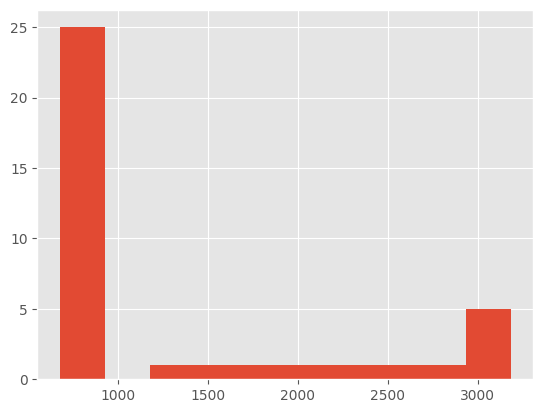

In [90]:
plt.hist(interpolated_ys)

In [91]:
interpolated_ys

array([ 675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825, 1228.03222099, 1577.27153042, 1865.13413342,
       2133.94151797, 2383.77265711, 2622.31538866, 2856.07093578,
       3074.55222421, 3183.93037495, 3183.93037495, 3183.93037495,
       3183.93037495])

In [92]:
new_heatmaps[1][:, 2]

array([ 675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825,  675.86167825,  675.86167825,  675.86167825,
        675.86167825, 1228.03222099, 1577.27153042, 1865.13413342,
       2133.94151797, 2383.77265711, 2622.31538866, 2856.07093578,
       3074.55222421, 3183.93037495, 3183.93037495, 3183.93037495,
       3183.93037495])

In [93]:
plt.style.use('default')

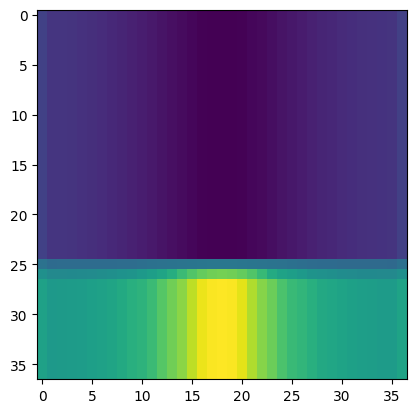

In [94]:
plt.imshow(new_heatmaps[123])
plt.show()

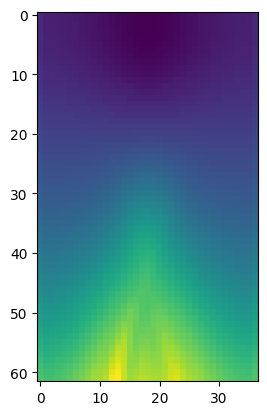

In [95]:
plt.imshow(heatmaps[1])
plt.show()

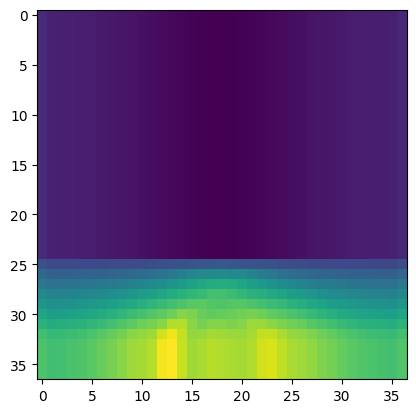

In [96]:
plt.imshow(new_heatmaps[1])
plt.show()

Then we normalize the pressure values.

In [97]:
# Create normalized heatmaps for all heatmaps

heatmaps_normalized = []

for i in tqdm(range(len(new_heatmaps))):
    # Normalize the value of new heatmap using sv
    inter = new_heatmaps[i] / df.iloc[cur_mid, 8]
    
    heatmaps_normalized.append(inter)

100%|████████████████████████████████████| 1363/1363 [00:00<00:00, 29240.19it/s]


In [98]:
min_ratio = np.min([np.min(h) for h in heatmaps_normalized])
max_ratio = np.max([np.max(h) for h in heatmaps_normalized])

print(min_ratio, max_ratio)

0.05758227971350974 15.327510751522187


In [99]:
# min_stress and max_stress are for generation normalized images in the old way
# for comparison

min_stress = np.min([np.min(h) for h in heatmaps])
max_stress = np.max([np.max(h) for h in heatmaps])

print(min_stress, max_stress)

27.0866533478187 11519.2058065428


In [102]:
indexes = list(range(len(heatmaps)))
np.random.shuffle(indexes)
indexes = indexes[:100]

rs_normalized_heatmaps = []
    
for i in tqdm(range(len(heatmaps_normalized))):
    
    cur_heatmap = heatmaps_normalized[i]
    normalized_heatmap = (cur_heatmap - min_ratio) / (max_ratio - min_ratio)
    normalized_heatmap = cv2.resize(normalized_heatmap, (256, 256))
    
    rs_normalized_heatmaps.append(normalized_heatmap)
    
    if i in indexes:
        # Uncomment here to save images
        pass
#         cur_img_uint = np.array(255 * normalized_heatmap, np.uint8)
#         cv2.imwrite('./data/temp_new/img-{:04}.png'.format(i), cur_img_uint)
        
#         old_heatmap = heatmaps[i]
#         normalized_heatmap_old = (old_heatmap - min_stress) / (max_stress - min_stress)
        
#         cur_img_uint = np.array(255 * normalized_heatmap_old, np.uint8)
#         cv2.imwrite('./data/temp_old/img-{:04}.png'.format(i), cur_img_uint)

100%|█████████████████████████████████████| 1363/1363 [00:00<00:00, 3419.88it/s]


In [103]:
# !montage ./data/temp_old/*.png -geometry +2+2 ./data/random-old-100.png
# !montage ./data/temp_new/*.png -geometry +2+2 ./data/random-new-100.png

In [104]:
np.savez_compressed('./data/special-normalized-displayment-heatmaps.npz',
                    rs_normalized_heatmaps=rs_normalized_heatmaps,
                    heatmaps_ids=heatmaps_ids,
                    dtype=object)